##imports!!!

In [1]:

# code and ideas in this document are adopted from https://neurodsp-tools.github.io/neurodsp/
# Thank you to all those who came before me, for your contributions.
# -Kenton Guarian

# general imports
from ref_functions import *
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
from neurodsp.utils import create_times
from neurodsp.utils import create_freqs

# imports for simulating periodic component
from neurodsp.sim import sim_bursty_oscillation
from neurodsp.sim import sim_variable_oscillation


# for simulating aperiodic component.
from neurodsp.sim import sim_powerlaw

# for plotting
from neurodsp.plts import plot_time_series
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
import matplotlib.pyplot as plt

# for bycycle analysis
import numpy as np
import sys
# from scipy.interpolate import make_interp_spline
from scipy.signal import resample
sys.path.insert(0, '/Users/kenton/HOME/coding/python/bycycle_env/bycycle')

import mycycle

%matplotlib inline


/Users/kenton/HOME/coding/python/bycycle_env/bycycle/mycycle/__init__.py:8: UserWarning: this is kenton's local version
  warnings.warn("this is kenton's local version",UserWarning)


Constants

In [2]:

n_seconds = 10
fs = 500
sliding_window_width=3
times = create_times(n_seconds=n_seconds, fs=fs)
freqs = create_freqs(freq_start=0, freq_stop=60)


thresholds = {
    'amp_fraction': 0.5,
    'amp_consistency': 0.2,
    'period_consistency': 0.2,
    'monotonicity': 0.2,
    'min_n_cycles': 1
}

simulating signals.

In [3]:
# bursts and signals taken from tutorial pages.
burst0 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations', burst_params={
    'n_cycles_burst': 3, 'n_cycles_off': 3})
burst1 = sig = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_params={
    'enter_burst': 0.2, 'leave_burst': 0.8})
burst2 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations',
                                burst_params={'n_cycles_burst': 3, 'n_cycles_off': 5})
burst3 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations', burst_params={
    'n_cycles_burst': 8, 'n_cycles_off': 20})
burst4 = sig = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_params={
    'enter_burst': 0.2, 'leave_burst': 0.8})
burst5 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations',
                                burst_params={'n_cycles_burst': 3, 'n_cycles_off': 3})

sig0 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=-2.0)

sig1 = sim_powerlaw(n_seconds=n_seconds, fs=fs,
                    exponent=-1.5, f_range=(2, None))
sig2 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=-0.5)

sig3 = sim_powerlaw(n_seconds=n_seconds, fs=fs,
                    exponent=-3, f_range=(2, None))


bursts = [burst3, burst5]
sigs = [sig0, sig1, sig2, sig3]
ratios = [10, 1, 0.5, 0.1, 0.0]

combined_sigs = [None]*(len(bursts) * len(sigs)*len(ratios))

# for y_vals in all_to_plot:
#     plot_time_series(times=times, sigs=y_vals)
# tested, looks good.

for i in range(len(bursts)):
    for j in range(len(sigs)):
        for k in range(len(ratios)):
            combined_sigs[len(sigs)*len(ratios)*i + len(ratios)
                          * j+k] = bursts[i]+10*ratios[len(ratios)-k-1]*sigs[j]
            

bm = mycycle.Bycycle()

/Users/kenton/HOME/coding/python/bycycle_env/bycycle/mycycle/objs/fit.py:36: UserWarning: 
                No burst detection thresholds are provided. This is not recommended. Please
                inspect your data and choose appropriate parameters for 'thresholds'.
                Default burst detection parameters are likely not well suited for your
                desired application.
                
  warnings.warn("""


Separate simulated signals based on known burst/aperiodic differences.

In [4]:
# TODO: do this.

K-Means on hyperparameters

In [5]:
# for sig in combined_sigs:
#     keys, hyperparams = extract_cleaned_hyperparameters_from_signal(bm, sig,500,3)
#     scaler = preprocessing.StandardScaler().fit(hyperparams)
#     print(keys)
#     print(hyperparams)
#     hyperparams_standardized = scaler.transform(hyperparams)
#     kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
#     kmeans = kmeans_model.fit_predict(hyperparams_standardized.T)
#     sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
#     sig_windows = get_signal_windows(sig, sig_window_indices)
#     sig_windows = sig_windows[1:len(sig_windows)-1]

#     group0 = []
#     group1 = []
#     for i in range(len(kmeans)):
#         if kmeans[i]==0:
#             group0.append(sig_windows[i-1])
#         else:
#             group1.append(sig_windows[i-1])

#     print(len(group0))
#     print(len(group1))
#     plt.figure()
#     for i in range(len(group0)):
#         plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
#     print(len(group0))
#     plt.figure()
#     for i in range(len(group1)):
#         plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
#     print(len(group1))
#     plt.show()


Add autocorrelation hyperparameters to the features NDarray

In [6]:
# for sig in combined_sigs:
#     # extract hypeparams
#     keys, hyperparams = extract_cleaned_hyperparameters_from_signal(bm, sig,500,3)
#     print(keys)
#     print(hyperparams)
#     sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
#     sig_windows = get_signal_windows(sig, sig_window_indices)
#     # sig_windows = sig_windows[1:len(sig_windows)-1]
#     corr = autocorrelate_all_windowed_signals(sig_windows)
#     longest_corr = 0
#     for i in range(len(corr)):
#         currcorrlen = len(corr[i])
#         if currcorrlen>longest_corr:
#             longest_corr = currcorrlen

#     hp_size = len(hyperparams)
#     hp0_size = len(hyperparams[0])
#     new_hyperparams = [np.zeros(hp0_size+longest_corr)]*hp_size
#     for i in range(len(hyperparams)):
#         print("i=%d"%i)
#         for j in range(hp0_size):
#             new_hyperparams[i][j] = hyperparams[i][j]
#         if i>0 and i < len(corr)-1:
#             for j in range(len(corr[i-1])):
#                 array_idx = hp0_size+j
#                 new_hyperparams[i][array_idx]=corr[i-1][j]
        

#     print(len(new_hyperparams))
#     print(hyperparams.size)
#     # standardize for k-means. take out and do for whole including autocorr
#     scaler = preprocessing.StandardScaler().fit(new_hyperparams)
#     new_hyperparams_standardized = scaler.transform(new_hyperparams)
#     kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
#     kmeans = kmeans_model.fit_predict(new_hyperparams_standardized.T)

#     print(new_hyperparams_standardized)
#     print(new_hyperparams)

#     # 
#     group0 = []
#     group1 = []
#     for i in range(len(kmeans)):
#         if kmeans[i]==0:
#             group0.append(sig_windows[i])
#         else:
#             group1.append(sig_windows[i])

#     print(len(group0))
#     print(len(group1))
#     plt.figure()
#     for i in range(len(group0)):
#         plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
#     print(len(group0))
#     plt.figure()
#     for i in range(len(group1)):
#         plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
#     print(len(group1))
#     plt.show()


Sliding Window Algorithm K-Means into two categories

959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
959
26
15
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
66
28
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
42
51
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
229
22

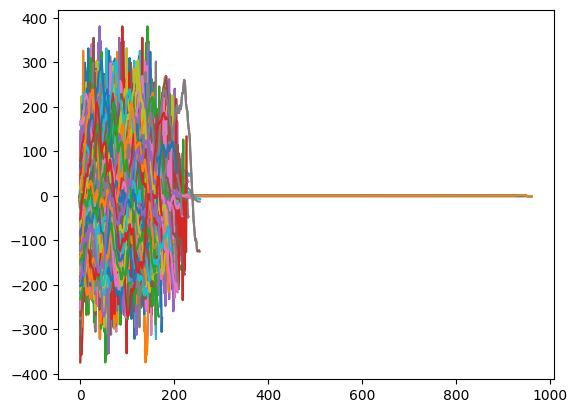

In [7]:
from neurodsp.filt import filter_signal_iir

for sig_index in range(len(combined_sigs)):
    bm = mycycle.Bycycle(thresholds=thresholds)
    # single recording
    sig = combined_sigs[sig_index]
    # sig=filter_signal_iir(sig= sig, fs=fs, pass_type='bandpass', f_range=(8,12), butterworth_order=3)

    # freqs, powers = compute_spectrum(sig=sig, fs=fs)
    # bm.report()
    # plt.show()


    sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
    sig_windows = get_signal_windows(sig, sig_window_indices)
    sig_windows_homogeneous_shape = [None]*len(sig_windows)

    longest_signal = 0
    for sig in sig_windows:
        length = len(sig)
        if length > longest_signal:
            longest_signal = length

    new_x = np.linspace(0,longest_signal,longest_signal)
    for i in range(len(sig_windows)):
        # spline = make_interp_spline(np.linspace(0,len(sig_windows[i]),len(sig_windows[i])), sig_windows[i])
        # sig_windows_homogeneous_shape[i]=spline(new_x)
        resampled_sig = resample(sig_windows[i],longest_signal)
        resampled_sig-=np.mean(resampled_sig)
        print(len(resampled_sig))
        sig_windows_homogeneous_shape[i]=resampled_sig
        
    scaler = preprocessing.StandardScaler().fit(sig_windows_homogeneous_shape)
    norm_homog_coll = scaler.transform(sig_windows_homogeneous_shape)
    # print(sig_windows.)
    # print(type(sig_windows))

    group0 = []
    group1 = []
    kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
    kmeans = kmeans_model.fit_predict(norm_homog_coll)
    for i in range(len(kmeans)):
        if kmeans[i]==0:
            group0.append(sig_windows_homogeneous_shape[i])
        else:
            group1.append(sig_windows_homogeneous_shape[i])

    # plt.figure()
    # for i in range(len(group0)):
    #     plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
    # plt.figure()
    # for i in range(len(group1)):
    #     plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
    # plt.show()

    print(len(group0))
    print(len(group1))

print("done")




Using Bandstop filter

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


23
24
67
28
43
50
44
49
56
35
23
24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


55
39
48
46
50
44
57
37
23
24
70
25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


37
58
24
66
40
52
23
24
37
53


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framewor

45
43
44
44
42
46
48
47
48
48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


44
51
34
61
57
34
48
47
53
44


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


49
48
51
44
56
38
48
47
21
70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framewor

46
45
22
68
41
51


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


48
47
48
47
41
48
33
55
42
46
done


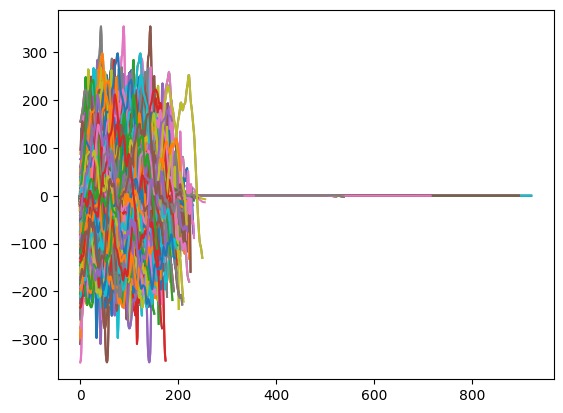

In [8]:
from neurodsp.filt import filter_signal_iir

for sig_index in range(len(combined_sigs)):
    bm = mycycle.Bycycle(thresholds=thresholds)
    # single recording
    sig = combined_sigs[sig_index]
    sig=filter_signal_iir(sig= sig, fs=fs, pass_type='bandpass', f_range=(1,100), butterworth_order=3)

    # freqs, powers = compute_spectrum(sig=sig, fs=fs)
    # bm.report()
    # plt.show()


    sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
    sig_windows = get_signal_windows(sig, sig_window_indices)
    sig_windows_homogeneous_shape = [None]*len(sig_windows)

    longest_signal = 0
    for sig in sig_windows:
        length = len(sig)
        if length > longest_signal:
            longest_signal = length

    new_x = np.linspace(0,longest_signal,longest_signal)
    for i in range(len(sig_windows)):
        # spline = make_interp_spline(np.linspace(0,len(sig_windows[i]),len(sig_windows[i])), sig_windows[i])
        # sig_windows_homogeneous_shape[i]=spline(new_x)
        resampled_sig = resample(sig_windows[i],longest_signal)
        resampled_sig-=np.mean(resampled_sig)
        # print(len(resampled_sig))
        sig_windows_homogeneous_shape[i]=resampled_sig
        
    scaler = preprocessing.StandardScaler().fit(sig_windows_homogeneous_shape)
    norm_homog_coll = scaler.transform(sig_windows_homogeneous_shape)
    # print(sig_windows.)
    # print(type(sig_windows))

    group0 = []
    group1 = []
    kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
    kmeans = kmeans_model.fit_predict(norm_homog_coll)
    for i in range(len(kmeans)):
        if kmeans[i]==0:
            group0.append(sig_windows_homogeneous_shape[i])
        else:
            group1.append(sig_windows_homogeneous_shape[i])

    # plt.figure()
    # for i in range(len(group0)):
        # plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
    # plt.figure()
    # for i in range(len(group1)):
        # plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)

    # plt.show()


    print(len(group0))
    print(len(group1))

print("done")




Using neurodsp dualthresh on windows

569
569
569
569
569
838
838
838
838
[(0, 490), (1314, 1883), (2716, 3282), (4118, 4677), (4684, 4998)]
[(489, 1315), (1882, 2717), (3281, 4119), (4676, 4685)]
525
525
525
525
907
907
907
[(0, 446), (1351, 1853), (2735, 3249), (4126, 4651)]
[(445, 1352), (1852, 2736), (3248, 4127)]
474
474
474
474
955
955
955
[(0, 412), (1352, 1826), (2757, 3217), (4170, 4622)]
[(411, 1353), (1825, 2758), (3216, 4171)]
398
398
398
398
398
398
987
987
987
987
987
[(0, 398), (1340, 1508), (1543, 1813), (2772, 3022), (3040, 3199), (4184, 4425)]
[(397, 1341), (1507, 1544), (1812, 2773), (3021, 3041), (3198, 4185)]
175
175
175
175
1818
1818
1818
1818
[(1028, 1174), (1325, 1473), (3289, 3379), (4201, 4376)]
[(0, 1029), (1173, 1326), (1472, 3290), (3378, 4202)]
569
569
569
569
569
838
838
838
838
[(0, 490), (1314, 1883), (2716, 3282), (4118, 4677), (4684, 4998)]
[(489, 1315), (1882, 2717), (3281, 4119), (4676, 4685)]
459
459
459
459
1001
1001
1001
1001
[(0, 381), (1380, 1839), (2785, 3220), (4192, 4607)]
[(0, 

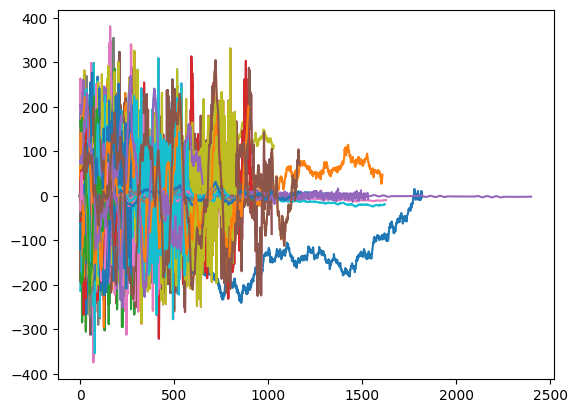

In [9]:
from neurodsp.burst import detect_bursts_dual_threshold as dualthresh
for i in range(len(combined_sigs)):
    curr_sig = combined_sigs[i]
    burst_bounds, complement_bounds = get_bursts_windows_dualthresh(curr_sig,fs,(8,12))
    burst_windows = get_signal_windows(sig=curr_sig, window_idx_collection=burst_bounds)
    burst_win_homog = [None]*len(burst_windows)
    comp_windows = get_signal_windows(sig=curr_sig, window_idx_collection=complement_bounds)
    comp_win_homog = [None]*len(comp_windows)

    longest_burst = 0
    for sig in burst_windows:
        length = len(sig)
        if length > longest_burst:
            longest_burst = length

    new_x = np.linspace(0,longest_burst,longest_burst)
    for i in range(len(burst_windows)):
        # spline = make_interp_spline(np.linspace(0,len(sig_windows[i]),len(sig_windows[i])), sig_windows[i])
        # sig_windows_homogeneous_shape[i]=spline(new_x)
        resampled_sig = resample(burst_windows[i],longest_burst)
        mean = np.mean(resampled_sig)
        resampled_sig-=mean
        print(len(resampled_sig))
        burst_win_homog[i]=resampled_sig

    longest_complement = 0
    for sig in comp_windows:
        length = len(sig)
        if length > longest_complement:
            longest_complement = length

    new_x = np.linspace(0,longest_complement,longest_complement)
    for i in range(len(comp_windows)):
        # spline = make_interp_spline(np.linspace(0,len(sig_windows[i]),len(sig_windows[i])), sig_windows[i])
        # sig_windows_homogeneous_shape[i]=spline(new_x)
        resampled_sig = resample(comp_windows[i],longest_complement)
        mean = np.mean(resampled_sig)
        resampled_sig-=mean
        print(len(resampled_sig))
        comp_win_homog[i]=resampled_sig
    # plt.show()
    # plt.figure()
    # for i in range(len(burst_win_homog)):
    #     plt.plot(np.linspace(0,len(burst_win_homog[i]),len(burst_win_homog[i])),burst_win_homog[i], alpha=0.2)
    # plt.show()
    # plt.figure()
    # plt.show()
    print(burst_bounds)
    print(complement_bounds)


    



On individual Cycles

In [10]:
from neurodsp.burst import detect_bursts_dual_threshold as dualthresh
for i in range(len(combined_sigs)):
    curr_sig = combined_sigs[i]
    burst_bounds, complement_bounds = get_bursts_windows_dualthresh(curr_sig,fs,(8,12))
    cycle_bounds_all = get_cycle_bounds(bm)
    cycle_bounds_bursting = select_bursting_cycles(cycle_bounds_all, burst_bounds)
    show_bounded_windows(curr_sig,cycle_bounds_bursting)


91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False, False]
91
5
(91, 5)
[True, False, False, False,

IndexError: invalid index to scalar variable.